In [10]:
import numpy as np 
import pandas as pd
import json
import glob

#path = "./events/events_England.json" 
#with open(path) as f:
#    data = json.load(f)
dfs = []
for file in glob.glob('./events/*.json'):
    with open(file) as f:
        json_data = pd.json_normalize(json.loads(f.read()))
        json_data['site'] = file.rsplit("/", 1)[-1]
    dfs.append(json_data)
df = pd.concat(dfs)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3251294 entries, 0 to 643149
Data columns (total 13 columns):
 #   Column        Dtype  
---  ------        -----  
 0   eventId       int64  
 1   subEventName  object 
 2   tags          object 
 3   playerId      int64  
 4   positions     object 
 5   matchId       int64  
 6   eventName     object 
 7   teamId        int64  
 8   matchPeriod   object 
 9   eventSec      float64
 10  subEventId    object 
 11  id            int64  
 12  site          object 
dtypes: float64(1), int64(5), object(7)
memory usage: 347.3+ MB


In [11]:
import numpy as np 
import pandas as pd
import json
import glob

#path = "./events/events_England.json" 
#with open(path) as f:
#    data = json.load(f)
dfs = []
for file in glob.glob('./events/*.json'):
    with open(file) as f:
        json_data = pd.json_normalize(json.loads(f.read()))
        json_data['site'] = file.rsplit("/", 1)[-1]
    dfs.append(json_data)
data = pd.concat(dfs)

train = pd.DataFrame(data)

path2 = "players.json" 

with open(path2) as f:
    play = json.load(f)

players = pd.DataFrame(play)




pd.unique(train['subEventName'])
shots = train[train['subEventName'] == 'Shot']

shots_model = pd.DataFrame(columns=["Goal","X","Y"], dtype=object)

for i,shot in shots.iterrows():
    
    
    shots_model.at[i,'Header'] = 0
    for tag in shot['tags']:
        if tag['id'] == 403:
            shots_model.at[i,'Header'] = 1
    
    
    #take distance from center of goal at y = 50, x position of goal is always 100
    shots_model.at[i,'X'] = 100-shot['positions'][0]['x']
    shots_model.at[i,'Y'] = shot['positions'][0]['y']
    shots_model.at[i,'C'] = abs(shot['positions'][0]['y'] - 50)
        
    #distance in meters
        
    x = shots_model.at[i,'X']* 105/100
    y = shots_model.at[i,'C']* 65/100
    shots_model.at[i,'Distance'] = np.sqrt(x**2 + y**2)
        
    angle = np.arctan(7.32 * x / (x**2 + y**2 - (7.32/2)**2))
        
    if angle < 0:
        angle = np.pi + angle
        
    shots_model.at[i,'Angle'] = angle
        
    #goal check
    shots_model.at[i,'Goal'] = 0
    shots_model.at[i,'Counter Attack'] = 0
    shots_model.at[i, 'Blocked'] = 0
    shots_model.at[i, 'Right Foot'] = 0
    shots_model.at[i,'wyId'] = shot['playerId']
    
    if shot['matchPeriod'] == '1H':
        shots_model.at[i, 'First Half'] = 1
    
    else:
        shots_model.at[i,'First Half'] = 0
        
    for tags in shot['tags']:
        if tags['id'] == 101:
            shots_model.at[i,'Goal'] = 1
            
        if tags['id'] == 1901:
            shots_model.at[i, 'Counter Attack'] = 1
        
        if tags['id'] == 2101:
            shots_model.at[i, 'Blocked'] = 1
        
        if tags['id'] == 402:
            shots_model.at[i, 'Right Foot'] = 1
            
            
        
shots_model['angle_degrees'] = shots_model['Angle'] * 180 / np.pi

shots_model = shots_model.merge(players, left_on = 'wyId' , right_on = 'wyId')

for i,shot in shots_model.iterrows():
    shots_model.at[i, 'strong foot'] = 0
    
    if shot['Right Foot'] == 1:
        if shot['foot'] == 'right':
            shots_model.at[i, 'strong foot'] = 1
    
    elif shot['Right Foot'] == 0:
        if shot['foot'] == 'left':
            shots_model.at[i, 'strong foot'] = 1

In [12]:
shots_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41843 entries, 0 to 41842
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Goal                   41843 non-null  object 
 1   X                      41843 non-null  object 
 2   Y                      41843 non-null  object 
 3   Header                 41843 non-null  float64
 4   C                      41843 non-null  float64
 5   Distance               41843 non-null  float64
 6   Angle                  41843 non-null  float64
 7   Counter Attack         41843 non-null  float64
 8   Blocked                41843 non-null  float64
 9   Right Foot             41843 non-null  float64
 10  wyId                   41843 non-null  float64
 11  First Half             41843 non-null  float64
 12  angle_degrees          41843 non-null  float64
 13  passportArea           41843 non-null  object 
 14  weight                 41843 non-null  int64  
 15  fi

In [13]:
shots_model.iloc[1]

Goal                                                                     0
X                                                                       26
Y                                                                       64
Header                                                                 0.0
C                                                                     14.0
Distance                                                         28.776727
Angle                                                             0.240538
Counter Attack                                                         0.0
Blocked                                                                1.0
Right Foot                                                             1.0
wyId                                                               20879.0
First Half                                                             1.0
angle_degrees                                                    13.781786
passportArea             

In [14]:
shots_model.drop(['passportArea', 'firstName','middleName', 'lastName',
                  'birthDate','role', 'birthArea', 'foot', 'shortName', 
                  'currentNationalTeamId'], axis = 1, inplace = True)

In [15]:
shots_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41843 entries, 0 to 41842
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Goal            41843 non-null  object 
 1   X               41843 non-null  object 
 2   Y               41843 non-null  object 
 3   Header          41843 non-null  float64
 4   C               41843 non-null  float64
 5   Distance        41843 non-null  float64
 6   Angle           41843 non-null  float64
 7   Counter Attack  41843 non-null  float64
 8   Blocked         41843 non-null  float64
 9   Right Foot      41843 non-null  float64
 10  wyId            41843 non-null  float64
 11  First Half      41843 non-null  float64
 12  angle_degrees   41843 non-null  float64
 13  weight          41843 non-null  int64  
 14  currentTeamId   41524 non-null  object 
 15  height          41843 non-null  int64  
 16  strong foot     41843 non-null  float64
dtypes: float64(11), int64(2), objec

In [16]:
shots_model.shape

(41843, 17)

In [17]:
shots_model.isnull().sum()

Goal                0
X                   0
Y                   0
Header              0
C                   0
Distance            0
Angle               0
Counter Attack      0
Blocked             0
Right Foot          0
wyId                0
First Half          0
angle_degrees       0
weight              0
currentTeamId     319
height              0
strong foot         0
dtype: int64

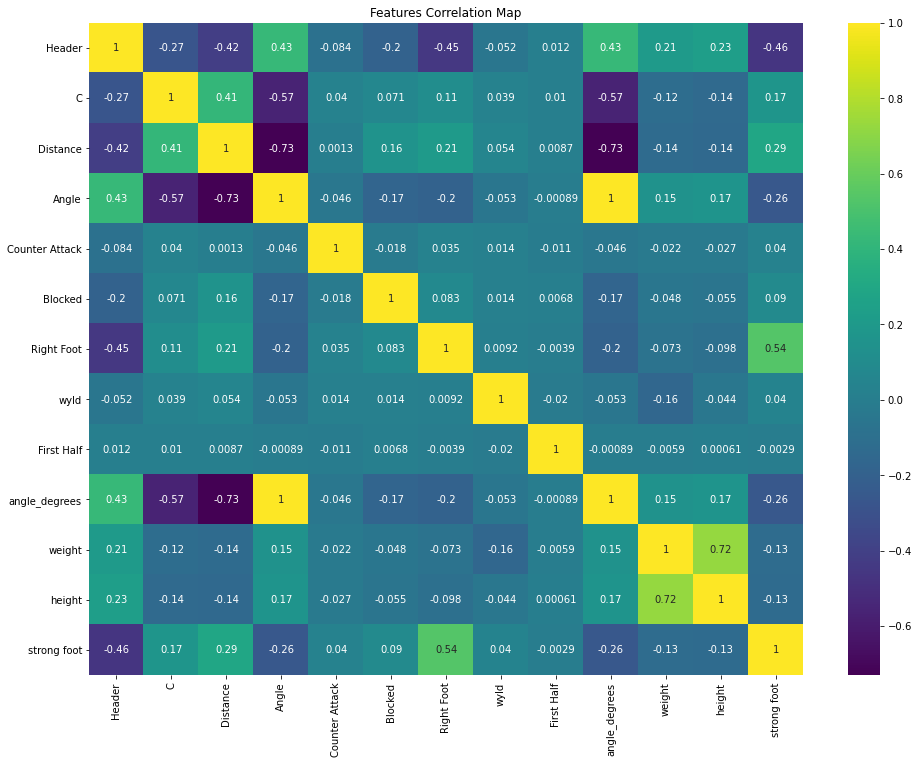

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns
import os

#os.mkdir('./image/')

plt.figure(figsize=(16,12))
ax = plt.axes()
sns.heatmap(shots_model.corr(),annot=True,cmap='viridis')
ax.set_title("Features Correlation Map")
plt.savefig('./image/CorrelationMap_AllEvent.jpg')
plt.show()

In [1]:
plt.figure(figsize=(10,6))
ax = plt.axes()
sns.scatterplot(x = 'Distance', y = 'angle_degrees', hue = 'Goal',size="Goal", sizes=(60, 30), 
                palette='dark', data = shots_model, style="Goal", markers = {0:"^", 1:"o"})
plt.xlabel("Distance (meters)")
plt.ylabel("Angle (degrees)")
ax.set_title("Analysis of Distance and Angle by Goal")
plt.savefig('./image/DistanceAngle_Analysis.jpg')
plt.show()

NameError: name 'plt' is not defined

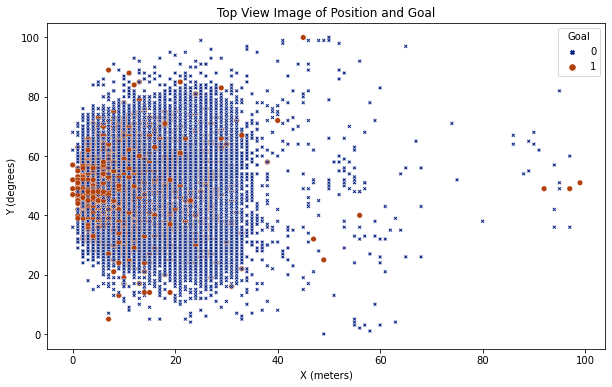

In [44]:
plt.figure(figsize=(10,6))
ax = plt.axes()
sns.scatterplot(x = 'X', y = 'Y', hue = 'Goal',size="Goal", sizes=(30, 15), 
                palette='dark', data = shots_model, style="Goal", markers = {0:"X", 1:"o"})
plt.xlabel("X (meters)")
plt.ylabel("Y (degrees)")
ax.set_title("Top View Image of Position and Goal")
plt.savefig('./image/Position_TopView.jpg')
plt.show()